In [1]:
%config InlineBackend.figure_format = 'retina'

import arraylake as al
import xarray as xr
import numpy as np
%xmode minimal

client = al.Client()

np.set_printoptions(threshold=10, edgeitems=2)
xr.set_options(display_expand_data=False)

Exception reporting mode: Minimal


We'll read the ERA5 AWS data

In [2]:
repo = client.get_repo("earthmover-public/era5-surface-aws")
session = repo.readonly_session("main")
ds = xr.open_dataset(session.store, group="temporal", engine="zarr")
ds

/Users/deepak/miniforge3/envs/xarray-release/lib/python3.12/site-packages/pvxarray/_version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


<xarray.Dataset> Size: 33TB
Dimensions:    (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/18)
    cape       (time, latitude, longitude) float32 2TB ...
    skt        (time, latitude, longitude) float32 2TB ...
    sp         (time, latitude, longitude) float32 2TB ...
    mslp       (time, latitude, longitude) float32 2TB ...
    sd         (time, latitude, longitude) float32 2TB ...
    d2         (time, latitude, longitude) float32 2TB ...
    ...         ...
    u10        (time, latitude, longitude) float32 2TB ...
    tcw        (time, latitude, longitude) float32 2TB ...
    v10        (time, latitude, longitude) float32 2TB ...
    v100       (time, latitude, longitude) float32 2TB ...
    u100       (time, latitude, longitude) float32 2TB ...
    tcc        (time, latitude, longitude) float32 2TB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-07-07 22:26:57 by combini...

## First up, slicing!

### Slicing in space


#### Subsetting to a box

We will extract the data for a little box around New Zealand.

These ranges are expressed in "coordinate space" that is, they have units of degrees


In [3]:
NZ_BBOX = {"longitude": slice(160, 180), "latitude": slice(-40, -50)}

Apply the slicers using the `.sel` method

In [4]:
subset = ds.sd.sel(NZ_BBOX)
subset

<xarray.DataArray 'sd' (time: 438312, latitude: 41, longitude: 81)> Size: 6GB
[1455634152 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

#### Selecting a point

In [5]:
ds.sel(latitude=-44, longitude=160)

<xarray.Dataset> Size: 35MB
Dimensions:    (time: 438312)
Coordinates:
    latitude   float64 8B -44.0
    longitude  float64 8B 160.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/18)
    cape       (time) float32 2MB ...
    skt        (time) float32 2MB ...
    sp         (time) float32 2MB ...
    mslp       (time) float32 2MB ...
    sd         (time) float32 2MB ...
    d2         (time) float32 2MB ...
    ...         ...
    u10        (time) float32 2MB ...
    tcw        (time) float32 2MB ...
    v10        (time) float32 2MB ...
    v100       (time) float32 2MB ...
    u100       (time) float32 2MB ...
    tcc        (time) float32 2MB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-07-07 22:26:57 by combini...

Note that the above works with exact locations that are present on the grid.

In [6]:
ds.sel(latitude=-44, longitude=161.23123)

KeyError: "not all values found in index 'longitude'. Try setting the `method` keyword argument (example: method='nearest')."

Specify `method="nearest"` to opt-in to nearest neighbour selection

In [7]:
ds.sel(latitude=-44, longitude=161.23123, method="nearest")

<xarray.Dataset> Size: 35MB
Dimensions:    (time: 438312)
Coordinates:
    latitude   float64 8B -44.0
    longitude  float64 8B 161.2
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/18)
    cape       (time) float32 2MB ...
    skt        (time) float32 2MB ...
    sp         (time) float32 2MB ...
    mslp       (time) float32 2MB ...
    sd         (time) float32 2MB ...
    d2         (time) float32 2MB ...
    ...         ...
    u10        (time) float32 2MB ...
    tcw        (time) float32 2MB ...
    v10        (time) float32 2MB ...
    v100       (time) float32 2MB ...
    u100       (time) float32 2MB ...
    tcc        (time) float32 2MB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-07-07 22:26:57 by combini...

### Slicing in time

This gets pretty fancy

In [8]:
# select a timestamp
subset.sel(time="2009-01-01 00:00")

<xarray.DataArray 'sd' (latitude: 41, longitude: 81)> Size: 13kB
[3321 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
    time       datetime64[ns] 8B 2009-01-01
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

In [9]:
# select a whole month
subset.sel(time="2009-03")

<xarray.DataArray 'sd' (time: 744, latitude: 41, longitude: 81)> Size: 10MB
[2470824 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 6kB 2009-03-01 ... 2009-03-31T23:00:00
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

In [10]:
# select a whole year
subset.sel(time="2009")

<xarray.DataArray 'sd' (time: 8760, latitude: 41, longitude: 81)> Size: 116MB
[29091960 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 70kB 2009-01-01 ... 2009-12-31T23:00:00
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

## Quick viz

Next visualize this subset

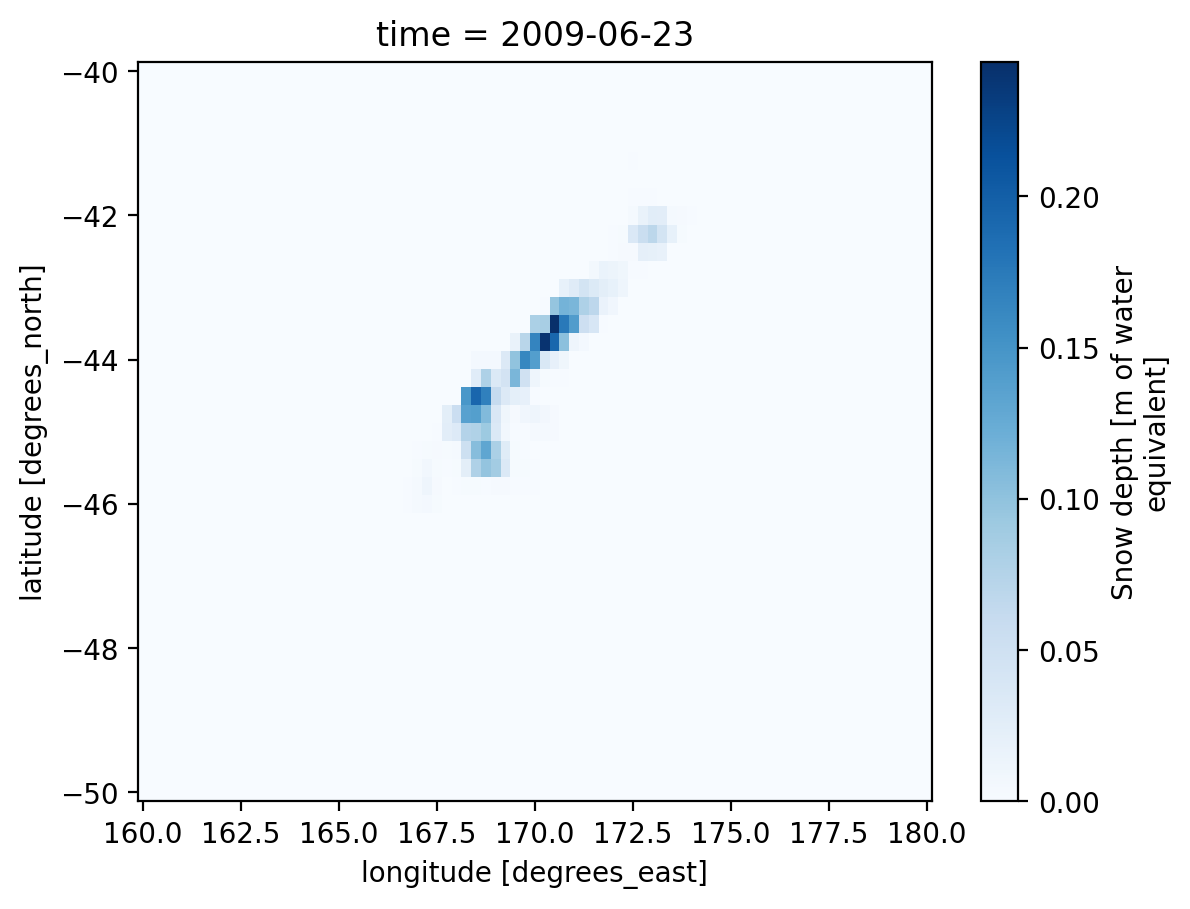

In [11]:
subset.sel(time="2009-06-23 00:00").plot(cmap="Blues")

## Let's estimate a monthly climatology

Climatology = "let's take all data for all Januaries and average them"

This is a _GroupBy_ problem.

We take the data, group by the "month" (`"time.month"`), and reduce the groups with the `mean`

<img src="https://foundations.projectpythia.org/build/xarray-split-apply-c-40541c57bd2dd8397d064155c4e63d4b.jpeg" alt="Xarray split-apply diagram" width="40%">

In [12]:
%time subset.load()

CPU times: user 4.22 s, sys: 922 ms, total: 5.14 s
Wall time: 11.2 s


<xarray.DataArray 'sd' (time: 438312, latitude: 41, longitude: 81)> Size: 6GB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

In [13]:
grouped = subset.groupby("time.month")
grouped

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': UniqueGrouper('month'), 12/12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

The GroupBy object has many methods; `mean` is one:

In [14]:
clim = grouped.mean()
clim

<xarray.DataArray 'sd' (month: 12, latitude: 41, longitude: 81)> Size: 159kB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/14)
    long_name:                                          Snow depth
    short_name:                                         sd
    units:                                              m of water equivalent
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    141
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

Let's look at some maps

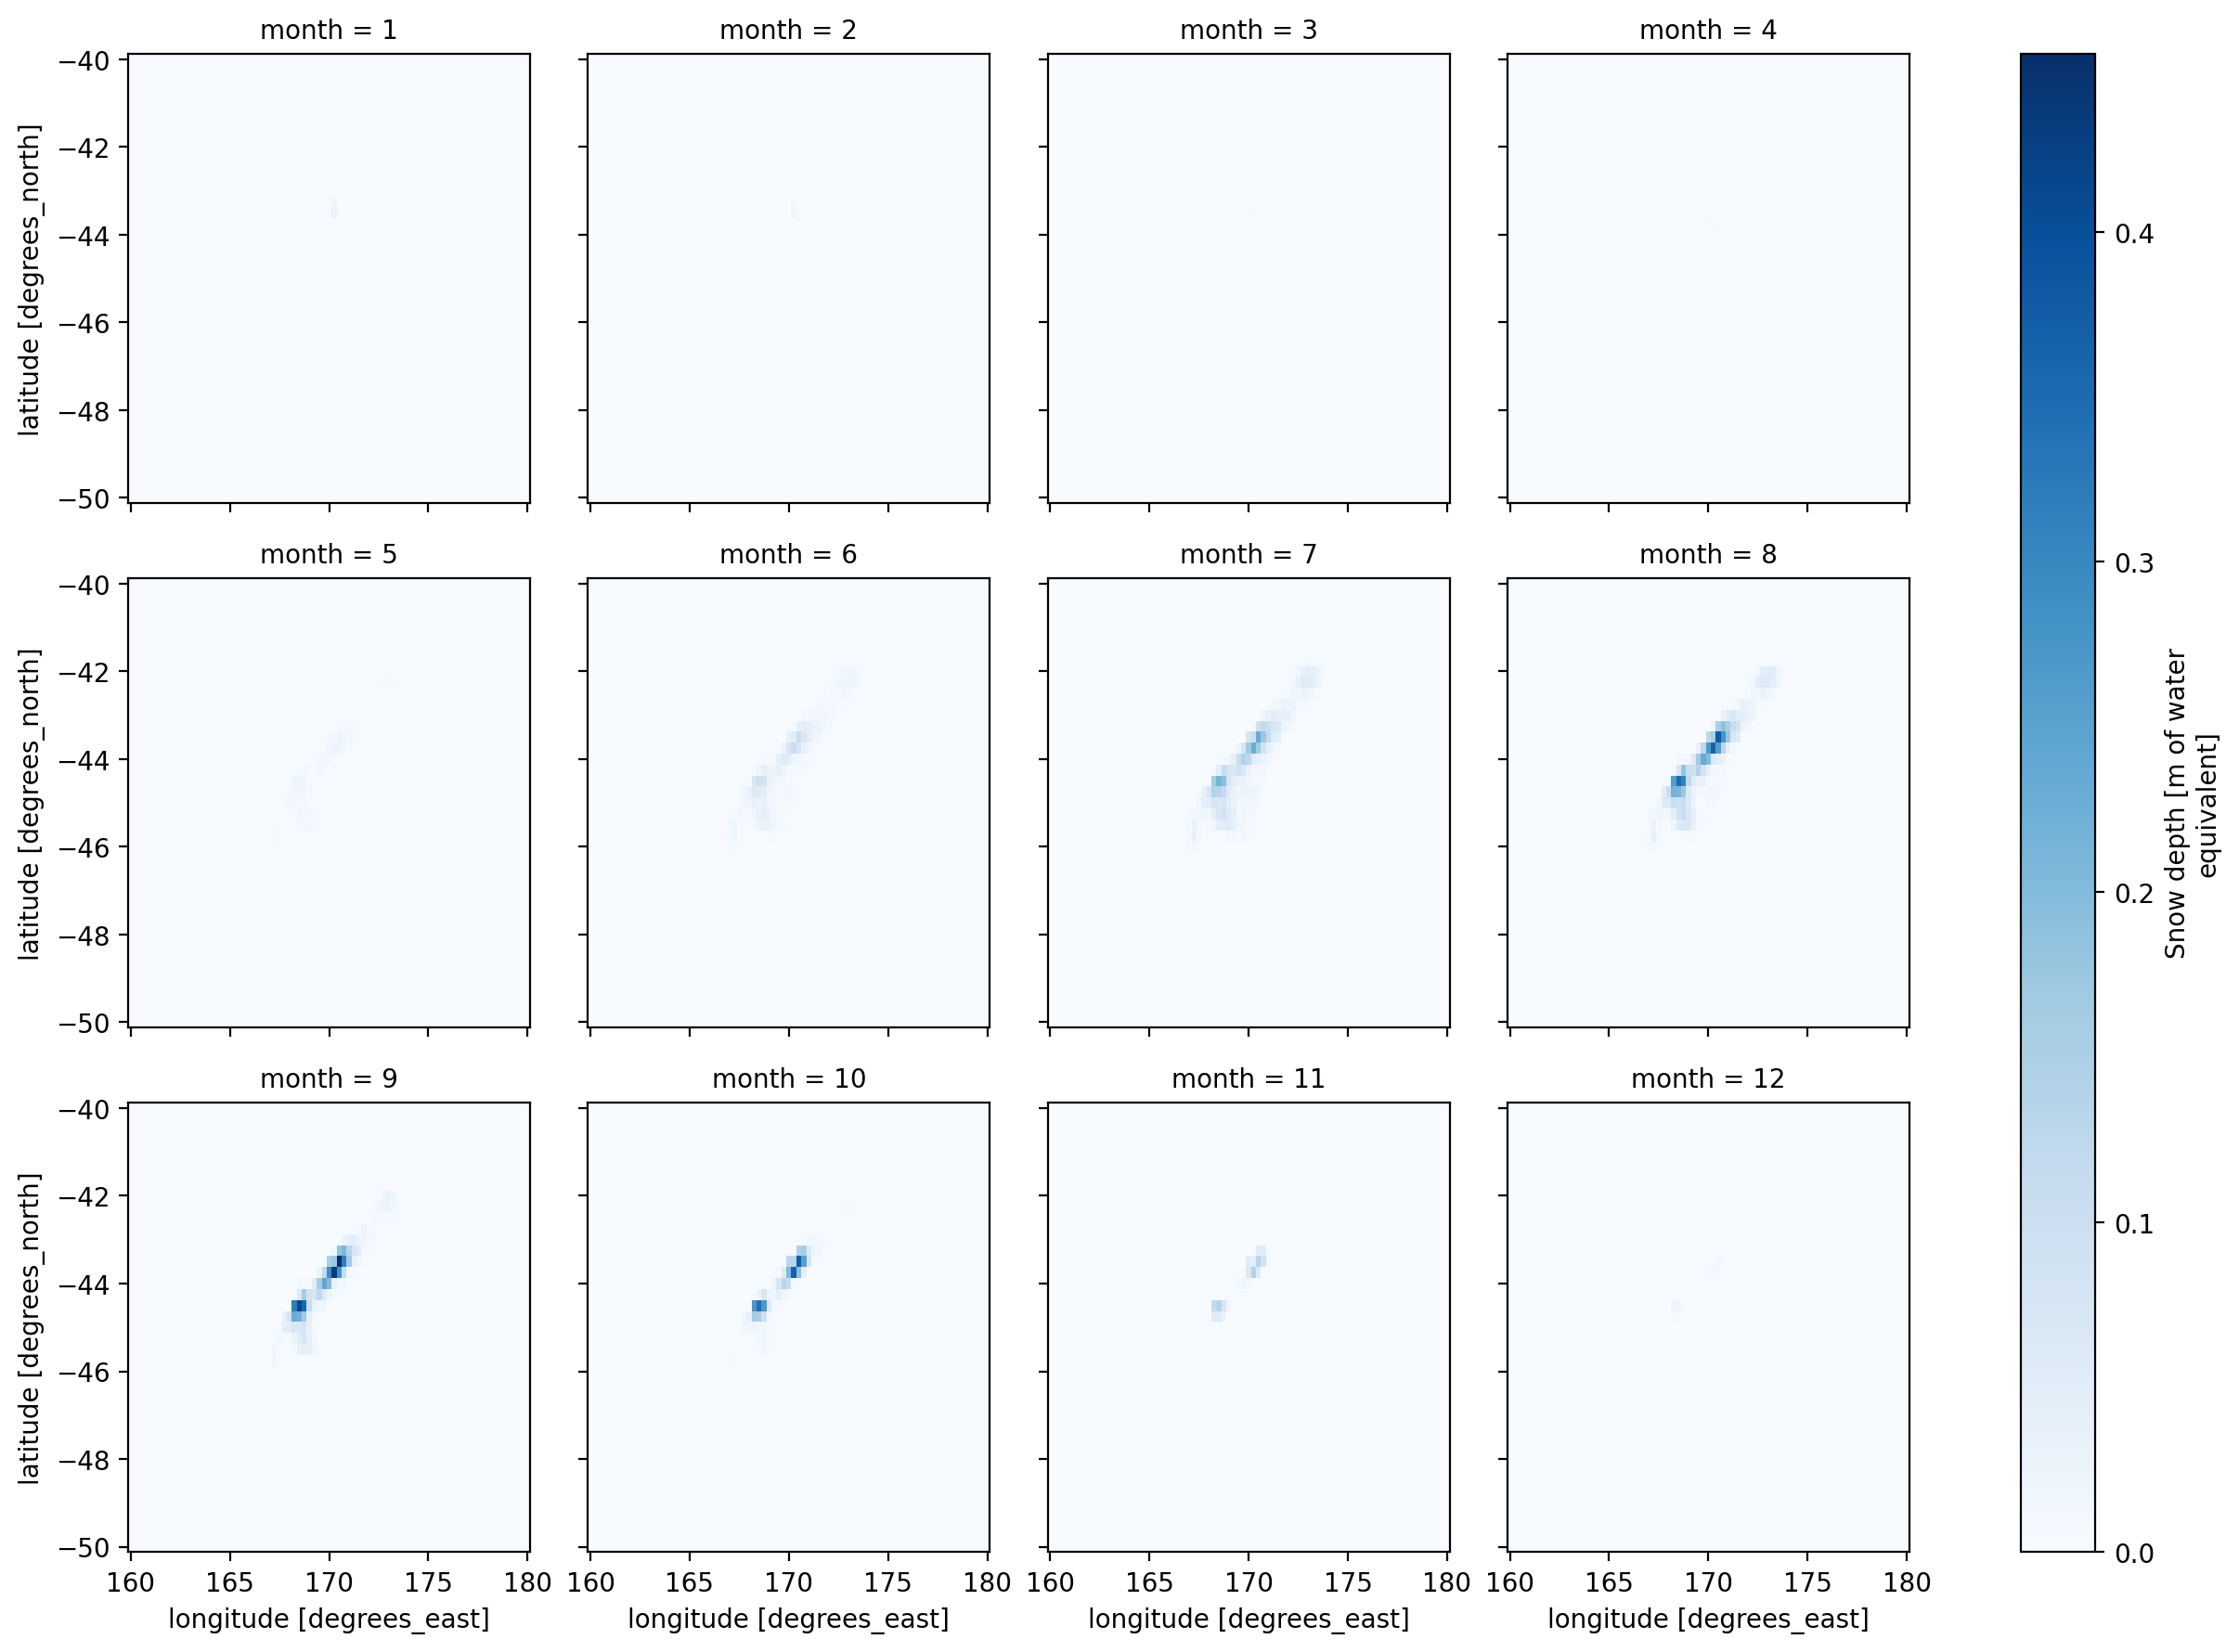

In [15]:
clim.plot(col="month", col_wrap=4, cmap="Blues")

### Exercise 1 : plot the monthly mean snow depth at Wellington

Location: 41°18′S 174°47′E

<details>

    ```python
    wellington = {"latitude": -41 + 18 / 60, "longitude": 174 + 47 / 60}
    # apparently snow is "exceptionally rare"
    clim.sel(wellington, method="nearest").plot()
    ```
</details>

### Exercise 2: Repeat the above for Mt. Hutt 

Latitude: -43.471667°, Longitude: 171.526444°

<details>
    
    ```python
    hutt = {"latitude": -43.471667, "longitude": 171.526444}
    subset.sel(hutt, method="nearest").plot()
    ```
    
</details>

## Estimate anomalies relative to monthly mean

In [19]:
anom = grouped - clim
anom

<xarray.DataArray 'sd' (time: 438312, latitude: 41, longitude: 81)> Size: 6GB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * latitude   (latitude) float64 328B -40.0 -40.25 -40.5 ... -49.5 -49.75 -50.0
  * longitude  (longitude) float64 648B 160.0 160.2 160.5 ... 179.5 179.8 180.0
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
    month      (time) int64 4MB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

In [41]:
monthly_mean_anom = anom.groupby("time.month").mean()

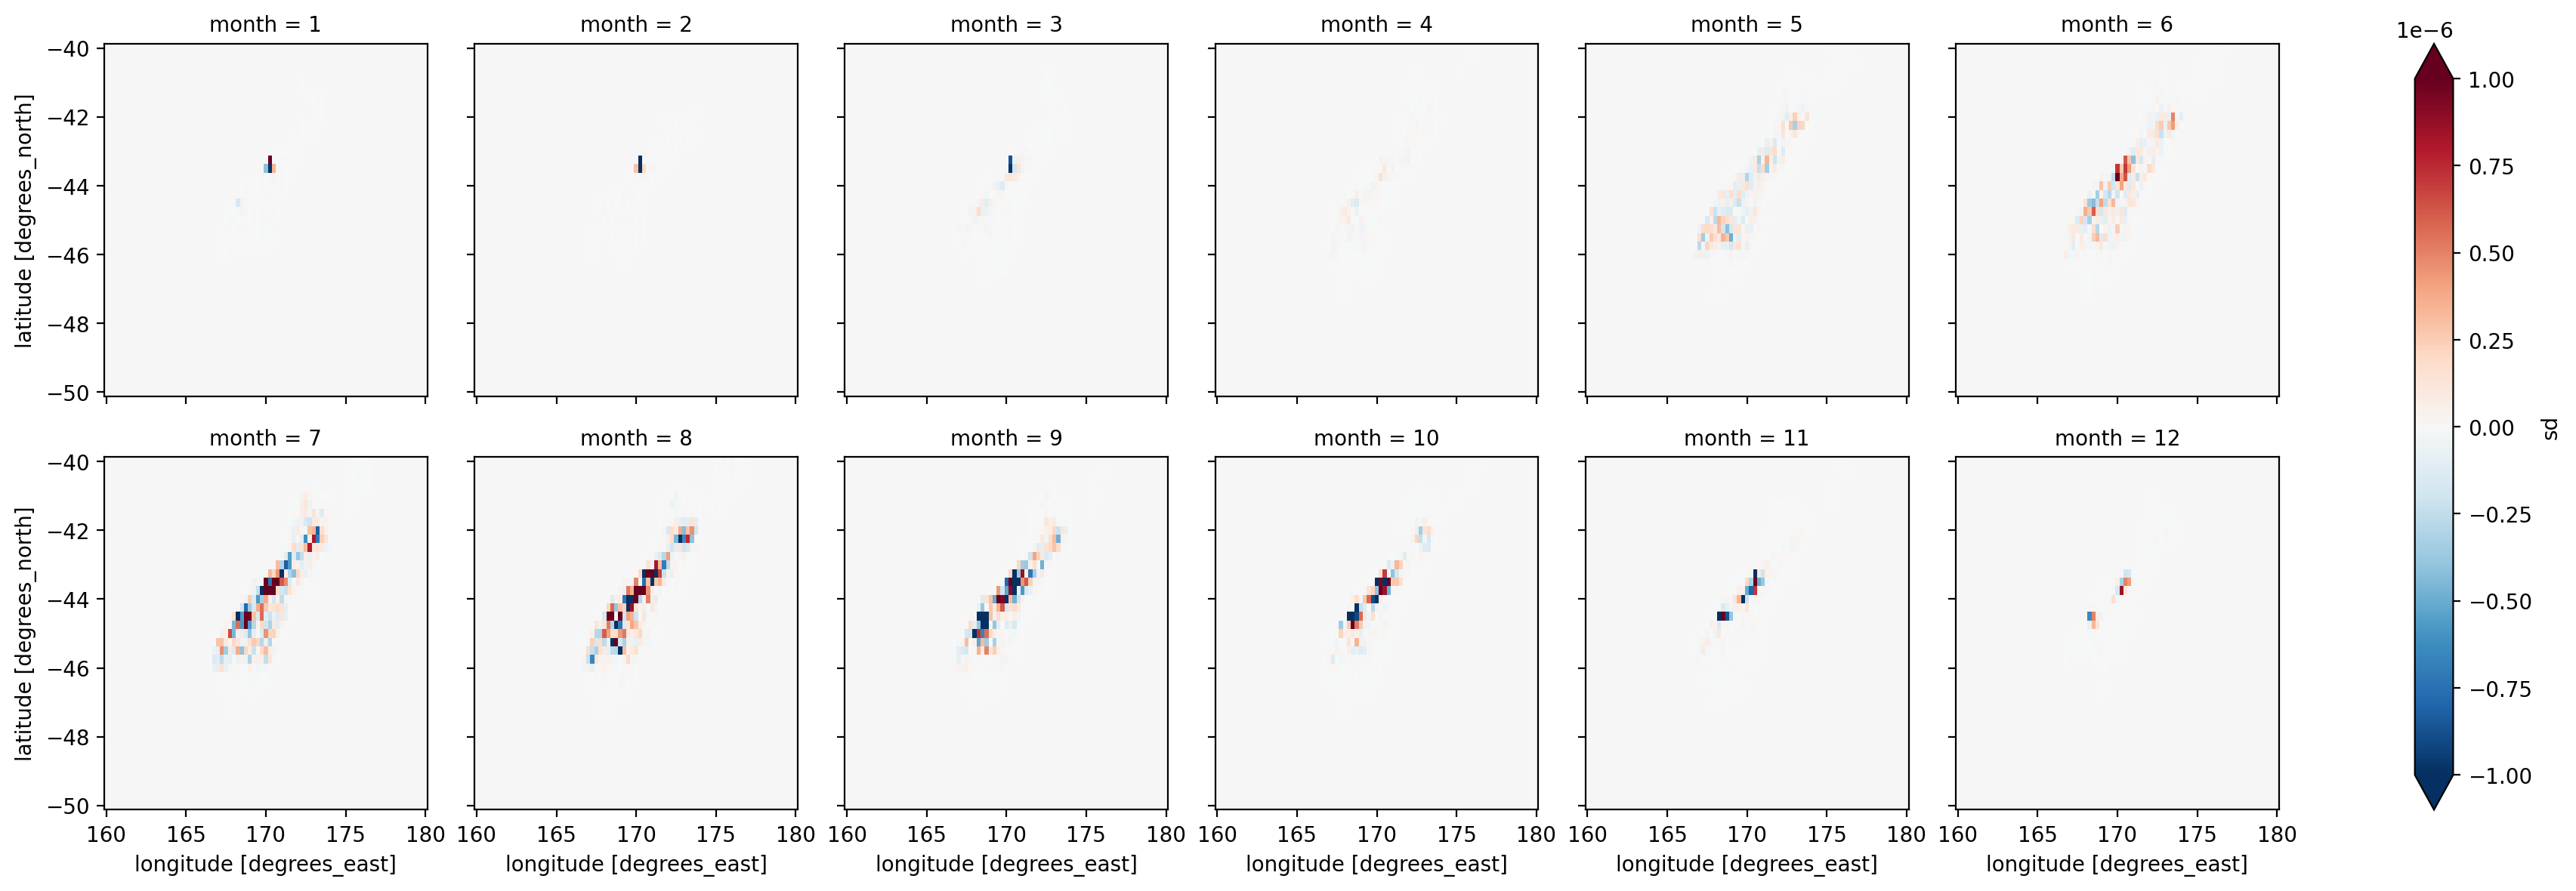

In [47]:
monthly_mean_anom.plot(col="month", col_wrap=6, vmin=-1e-6, vmax=1e-6, cmap="RdBu_r")

## Resampling to a different frequency

In [48]:
ts = anom.resample(time="QS").mean()

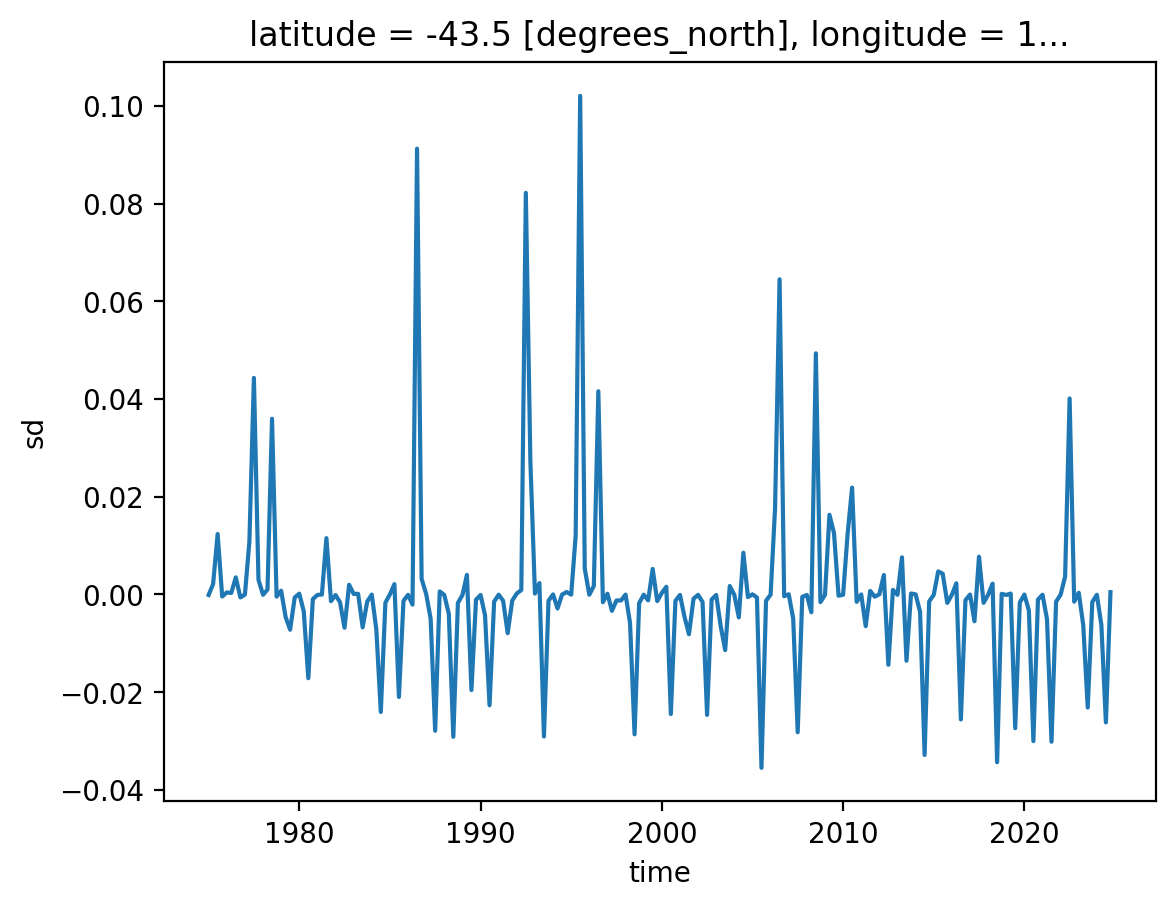

In [49]:
hutt = {"latitude": -43.471667, "longitude": 171.526444}
ts.sel(hutt, method="nearest").plot()

## More complex metrics